# Sistema de Recomendação por imagem


O objetivo desse código é criar um Sistema de Recomendação por imagens que sugira produtos visualmente similares com base em suas características visuais (como cor, formato e textura). O sistema é criado a partir do treinamento de uma rede neural com um dataset imagens de produtos do Kaggle com a rede pré-treinada ResNet.

In [1]:
# Importando um dataset com produtos do Kaggle

import kagglehub

path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")

print("Path to dataset files:", path)


Path to dataset files: /root/.cache/kagglehub/datasets/paramaggarwal/fashion-product-images-dataset/versions/1


In [2]:
# Explorando o dataset

import os

# Listar os arquivos baixados
dataset_path = path  # Caminho do dataset
print("Arquivos no dataset:")
print(os.listdir(dataset_path))

# Definir caminho do dataset
dataset_dir = os.path.join(dataset_path, "fashion-dataset")

# Listar arquivos e subpastas dentro do diretório principal
print("Conteúdo da pasta fashion-dataset:")
print(os.listdir(dataset_dir))


Arquivos no dataset:
['fashion-dataset']
Conteúdo da pasta fashion-dataset:
['images.csv', 'fashion-dataset', 'styles.csv', 'images', 'styles']


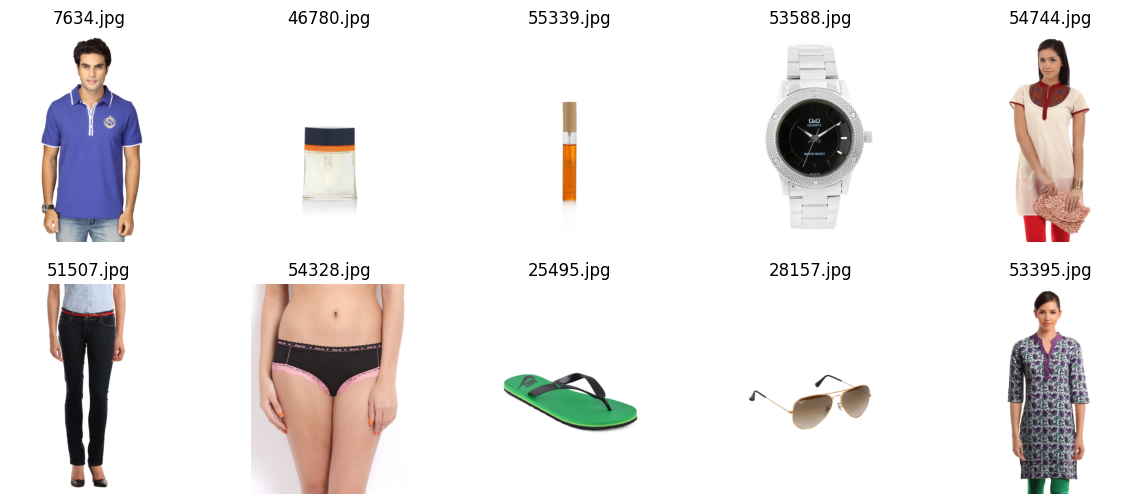

In [3]:
# Explorando as imagens

# Caminho das imagens
images_path = os.path.join(dataset_dir, "images")

import random
import matplotlib.pyplot as plt
import cv2

# Selecionar 10 imagens aleatórias para visualizar
sample_images = random.sample(os.listdir(images_path), 10)

# Exibir as imagens
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for img_file, ax in zip(sample_images, axes.ravel()):
    img = cv2.imread(os.path.join(images_path, img_file))  # Carregar imagem
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Converter de BGR para RGB
    ax.imshow(img)
    ax.set_title(img_file)  # Nome do arquivo
    ax.axis("off")

plt.show()


In [4]:
# Explorando as classes do dataset

import pandas as pd

# Carregar os metadados ignorando erros
styles_path = os.path.join(dataset_dir, "styles.csv")

df = pd.read_csv(styles_path, on_bad_lines="skip", encoding="utf-8")

# Exibir as colunas disponíveis
print("Colunas do dataset:", df.columns)

# Exibir categorias únicas em algumas colunas relevantes
print("\nCategorias disponíveis:")
print("Master Category:\n", df["masterCategory"].unique())
print("\nSub Category:\n", df["subCategory"].unique())
print("\nArticle Type:\n", df["articleType"].unique()) # A princípio, parece ser o mais adequado usar 'articleType' como classe




Colunas do dataset: Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')

Categorias disponíveis:
Master Category:
 ['Apparel' 'Accessories' 'Footwear' 'Personal Care' 'Free Items'
 'Sporting Goods' 'Home']

Sub Category:
 ['Topwear' 'Bottomwear' 'Watches' 'Socks' 'Shoes' 'Belts' 'Flip Flops'
 'Bags' 'Innerwear' 'Sandal' 'Shoe Accessories' 'Fragrance' 'Jewellery'
 'Lips' 'Saree' 'Eyewear' 'Nails' 'Scarves' 'Dress'
 'Loungewear and Nightwear' 'Wallets' 'Apparel Set' 'Headwear' 'Mufflers'
 'Skin Care' 'Makeup' 'Free Gifts' 'Ties' 'Accessories' 'Skin'
 'Beauty Accessories' 'Water Bottle' 'Eyes' 'Bath and Body' 'Gloves'
 'Sports Accessories' 'Cufflinks' 'Sports Equipment' 'Stoles' 'Hair'
 'Perfumes' 'Home Furnishing' 'Umbrellas' 'Wristbands' 'Vouchers']

Article Type:
 ['Shirts' 'Jeans' 'Watches' 'Track Pants' 'Tshirts' 'Socks' 'Casual Shoes'
 'Belts' 'Flip Flops' 'Handbags' 'Tops

In [5]:
# Definir as classes escolhidas
selected_classes = ["Tshirts", "Sunglasses", "Caps", "Casual Shoes", "Sports Shoes"]

# Filtrar o dataset apenas com as classes selecionadas
filtered_df = df[df["articleType"].isin(selected_classes)]

# Contar quantas amostras existem para cada classe
print(filtered_df["articleType"].value_counts())


articleType
Tshirts         7067
Casual Shoes    2845
Sports Shoes    2036
Sunglasses      1073
Caps             283
Name: count, dtype: int64


In [6]:
# Estruturando os diretórios e ocupando com 283 imagens de cada classe

import shutil

images_dir = os.path.join(dataset_dir, "images")
output_dir = "/content/dataset"

# Criar Diretórios das classes
classes = ["Tshirts", "Casual Shoes", "Sunglasses", "Caps"]
for class_name in classes:
    os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)

# Filtrar apenas as classes selecionadas e balancear para 283 imagens cada
df_filtered = (
    df[df["articleType"].isin(classes)]
    .groupby("articleType", group_keys=False)
    .apply(lambda x: x.sample(n=283, random_state=42))
    .reset_index(drop=True)
)

# Copiar imagens para o novo diretório
for _, row in df_filtered.iterrows():
    img_filename = f"{row['id']}.jpg"
    src_path = os.path.join(images_dir, img_filename)
    dst_path = os.path.join(output_dir, row["articleType"], img_filename)

    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)

print("Dataset balanceado criado com sucesso!")

<ipython-input-6-bda13c7f07b9>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=283, random_state=42))


Dataset balanceado criado com sucesso!


In [7]:
# Carregando a ResNet, processando as imagens e salvando os embenddings

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import pickle
from tqdm import tqdm  # Para visualizar progresso

# Carregar modelo ResNet50 sem a camada de classificação final
resnet_model = ResNet50(weights="imagenet", include_top=False, pooling="avg")

# Diretório das imagens processadas
output_dir = "/content/dataset"

# Dicionário para armazenar os embeddings
embeddings = {}

# Função para extrair features de uma única imagem
def extract_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))  # Redimensiona para 224x224
    img_array = image.img_to_array(img)  # Converte para array NumPy
    img_array = np.expand_dims(img_array, axis=0)  # Adiciona dimensão extra (batch)
    img_array = preprocess_input(img_array)  # Pré-processamento específico da ResNet

    features = model.predict(img_array)  # Obtém os embeddings
    return features.flatten()  # Transforma em vetor 1D

# Processar todas as imagens das classes
for class_name in os.listdir(output_dir):
    class_path = os.path.join(output_dir, class_name)
    if os.path.isdir(class_path):
        embeddings[class_name] = {}

        for img_file in tqdm(os.listdir(class_path), desc=f"Processando {class_name}"):
            img_path = os.path.join(class_path, img_file)
            embeddings[class_name][img_file] = extract_features(img_path, resnet_model)

# Salvar embeddings para uso posterior
with open("fashion_embeddings.pkl", "wb") as f:
    pickle.dump(embeddings, f)

print("Extração de embeddings concluída e salva em 'fashion_embeddings.pkl'!")

Processando Sunglasses:   0%|          | 0/283 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Processando Sunglasses:   0%|          | 1/283 [00:03<14:38,  3.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Sunglasses:   1%|          | 2/283 [00:03<07:04,  1.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Sunglasses:   1%|          | 3/283 [00:03<04:37,  1.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Sunglasses:   1%|▏         | 4/283 [00:04<03:31,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Sunglasses:   2%|▏         | 5/283 [00:04<02:43,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Processando Sunglasses:   2%|▏         | 6/283 [00:04<02:23,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Processando Sunglasses:   2%|▏         | 7/283 [00:05<02:11,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Processando Sunglasses:   3%|▎         | 8/283 [00:05<02:02,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Sunglasses:   3%|▎         | 9/283 [00:06<01:58,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Sunglasses:   4%|▎         | 10/283 [00:06<01:53,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Processando Sunglasses:   4%|▍         | 11/283 [00:06<01:50,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Sunglasses:   4%|▍         | 12/283 [00:07<01:39,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Processando Sunglasses:   5%|▍         | 13/283 [00:07<01:41,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Processando Sunglasses:   5%|▍         | 14/283 [00:07<01:41,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Sunglasses:   5%|▌         | 15/283 [00:08<01:40,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Sunglasses:   6%|▌         | 16/283 [00:08<01:31,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Processando Sunglasses:   6%|▌         | 17/283 [00:08<01:33,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Sunglasses:   6%|▋         | 18/283 [00:09<01:36,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Sunglasses:   7%|▋         | 19/283 [00:09<01:36,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Sunglasses:   7%|▋         | 20/283 [00:10<01:31,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Sunglasses:   7%|▋         | 21/283 [00:10<01:33,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Processando Sunglasses:   8%|▊         | 22/283 [00:10<01:25,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Processando Sunglasses:   8%|▊         | 23/283 [00:11<01:30,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Sunglasses:   8%|▊         | 24/283 [00:11<01:31,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


Processando Sunglasses:   9%|▉         | 25/283 [00:11<01:24,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Processando Sunglasses:   9%|▉         | 26/283 [00:12<01:27,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


Processando Sunglasses:  10%|▉         | 27/283 [00:12<01:29,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Sunglasses:  10%|▉         | 28/283 [00:12<01:23,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


Processando Sunglasses:  10%|█         | 29/283 [00:13<01:27,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


Processando Sunglasses:  11%|█         | 30/283 [00:13<01:57,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


Processando Sunglasses:  11%|█         | 31/283 [00:14<02:18,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


Processando Sunglasses:  11%|█▏        | 32/283 [00:15<02:30,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Sunglasses:  12%|█▏        | 33/283 [00:15<02:13,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processando Sunglasses:  12%|█▏        | 34/283 [00:16<02:01,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Sunglasses:  12%|█▏        | 35/283 [00:16<01:46,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Sunglasses:  13%|█▎        | 36/283 [00:16<01:41,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Sunglasses:  13%|█▎        | 37/283 [00:17<01:39,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Sunglasses:  13%|█▎        | 38/283 [00:17<01:29,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Processando Sunglasses:  14%|█▍        | 39/283 [00:17<01:30,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Sunglasses:  14%|█▍        | 40/283 [00:18<01:25,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Sunglasses:  14%|█▍        | 41/283 [00:18<01:27,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Sunglasses:  15%|█▍        | 42/283 [00:18<01:22,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Sunglasses:  15%|█▌        | 43/283 [00:19<01:18,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Sunglasses:  16%|█▌        | 44/283 [00:19<01:22,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Processando Sunglasses:  16%|█▌        | 45/283 [00:19<01:27,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Sunglasses:  16%|█▋        | 46/283 [00:20<01:20,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Sunglasses:  17%|█▋        | 47/283 [00:20<01:24,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Sunglasses:  17%|█▋        | 48/283 [00:20<01:17,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Sunglasses:  17%|█▋        | 49/283 [00:21<01:13,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Processando Sunglasses:  18%|█▊        | 50/283 [00:21<01:17,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Processando Sunglasses:  18%|█▊        | 51/283 [00:21<01:20,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Sunglasses:  18%|█▊        | 52/283 [00:22<01:14,  3.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Sunglasses:  19%|█▊        | 53/283 [00:22<01:12,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Processando Sunglasses:  19%|█▉        | 54/283 [00:22<01:16,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Sunglasses:  19%|█▉        | 55/283 [00:23<01:12,  3.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Sunglasses:  20%|█▉        | 56/283 [00:23<01:09,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Processando Sunglasses:  20%|██        | 57/283 [00:23<01:07,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Sunglasses:  20%|██        | 58/283 [00:23<01:05,  3.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Processando Sunglasses:  21%|██        | 59/283 [00:24<01:12,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Sunglasses:  21%|██        | 60/283 [00:24<01:15,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Sunglasses:  22%|██▏       | 61/283 [00:25<01:17,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


Processando Sunglasses:  22%|██▏       | 62/283 [00:25<01:19,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


Processando Sunglasses:  22%|██▏       | 63/283 [00:26<01:43,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


Processando Sunglasses:  23%|██▎       | 64/283 [00:26<01:41,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


Processando Sunglasses:  23%|██▎       | 65/283 [00:27<01:59,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Processando Sunglasses:  23%|██▎       | 66/283 [00:27<01:50,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Sunglasses:  24%|██▎       | 67/283 [00:28<01:36,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Sunglasses:  24%|██▍       | 68/283 [00:28<01:31,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Processando Sunglasses:  24%|██▍       | 69/283 [00:28<01:28,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Sunglasses:  25%|██▍       | 70/283 [00:29<01:25,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Processando Sunglasses:  25%|██▌       | 71/283 [00:29<01:17,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Sunglasses:  25%|██▌       | 72/283 [00:29<01:13,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Processando Sunglasses:  26%|██▌       | 73/283 [00:30<01:15,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Processando Sunglasses:  26%|██▌       | 74/283 [00:30<01:15,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Sunglasses:  27%|██▋       | 75/283 [00:30<01:16,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Sunglasses:  27%|██▋       | 76/283 [00:31<01:16,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Sunglasses:  27%|██▋       | 77/283 [00:31<01:16,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Sunglasses:  28%|██▊       | 78/283 [00:32<01:16,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Processando Sunglasses:  28%|██▊       | 79/283 [00:32<01:16,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Sunglasses:  28%|██▊       | 80/283 [00:32<01:10,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Sunglasses:  29%|██▊       | 81/283 [00:33<01:15,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processando Sunglasses:  29%|██▉       | 82/283 [00:33<01:14,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Processando Sunglasses:  29%|██▉       | 83/283 [00:33<01:14,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Sunglasses:  30%|██▉       | 84/283 [00:34<01:14,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processando Sunglasses:  30%|███       | 85/283 [00:34<01:08,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Processando Sunglasses:  30%|███       | 86/283 [00:34<01:09,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Sunglasses:  31%|███       | 87/283 [00:35<01:10,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Processando Sunglasses:  31%|███       | 88/283 [00:35<01:04,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Processando Sunglasses:  31%|███▏      | 89/283 [00:35<01:02,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Sunglasses:  32%|███▏      | 90/283 [00:36<01:06,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Sunglasses:  32%|███▏      | 91/283 [00:36<01:07,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Processando Sunglasses:  33%|███▎      | 92/283 [00:36<01:04,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Sunglasses:  33%|███▎      | 93/283 [00:37<01:08,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Sunglasses:  33%|███▎      | 94/283 [00:37<01:03,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


Processando Sunglasses:  34%|███▎      | 95/283 [00:38<01:26,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


Processando Sunglasses:  34%|███▍      | 96/283 [00:39<01:40,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


Processando Sunglasses:  34%|███▍      | 97/283 [00:39<01:52,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Sunglasses:  35%|███▍      | 98/283 [00:40<01:34,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Processando Sunglasses:  35%|███▍      | 99/283 [00:40<01:20,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Processando Sunglasses:  35%|███▌      | 100/283 [00:40<01:17,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Sunglasses:  36%|███▌      | 101/283 [00:41<01:15,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Sunglasses:  36%|███▌      | 102/283 [00:41<01:12,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Sunglasses:  36%|███▋      | 103/283 [00:41<01:11,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Sunglasses:  37%|███▋      | 104/283 [00:42<01:05,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Sunglasses:  37%|███▋      | 105/283 [00:42<01:05,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Sunglasses:  37%|███▋      | 106/283 [00:42<01:01,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Sunglasses:  38%|███▊      | 107/283 [00:43<00:59,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Sunglasses:  38%|███▊      | 108/283 [00:43<01:01,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Sunglasses:  39%|███▊      | 109/283 [00:43<01:02,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Sunglasses:  39%|███▉      | 110/283 [00:44<01:03,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Sunglasses:  39%|███▉      | 111/283 [00:44<00:58,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Sunglasses:  40%|███▉      | 112/283 [00:44<00:55,  3.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Sunglasses:  40%|███▉      | 113/283 [00:45<00:54,  3.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Sunglasses:  40%|████      | 114/283 [00:45<00:57,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Sunglasses:  41%|████      | 115/283 [00:45<00:55,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Sunglasses:  41%|████      | 116/283 [00:46<00:58,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Sunglasses:  41%|████▏     | 117/283 [00:46<00:59,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Sunglasses:  42%|████▏     | 118/283 [00:47<01:00,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Sunglasses:  42%|████▏     | 119/283 [00:47<00:55,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Sunglasses:  42%|████▏     | 120/283 [00:47<00:53,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Sunglasses:  43%|████▎     | 121/283 [00:48<00:55,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Sunglasses:  43%|████▎     | 122/283 [00:48<00:52,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Processando Sunglasses:  43%|████▎     | 123/283 [00:48<00:54,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Sunglasses:  44%|████▍     | 124/283 [00:49<00:56,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Sunglasses:  44%|████▍     | 125/283 [00:49<00:52,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Sunglasses:  45%|████▍     | 126/283 [00:49<00:55,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Processando Sunglasses:  45%|████▍     | 127/283 [00:50<00:56,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


Processando Sunglasses:  45%|████▌     | 128/283 [00:50<01:13,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


Processando Sunglasses:  46%|████▌     | 129/283 [00:51<01:25,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


Processando Sunglasses:  46%|████▌     | 130/283 [00:52<01:33,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Sunglasses:  46%|████▋     | 131/283 [00:52<01:22,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Sunglasses:  47%|████▋     | 132/283 [00:53<01:14,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Sunglasses:  47%|████▋     | 133/283 [00:53<01:08,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Sunglasses:  47%|████▋     | 134/283 [00:53<01:04,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Sunglasses:  48%|████▊     | 135/283 [00:54<01:01,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Sunglasses:  48%|████▊     | 136/283 [00:54<01:00,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Sunglasses:  48%|████▊     | 137/283 [00:54<00:54,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Processando Sunglasses:  49%|████▉     | 138/283 [00:55<00:50,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Sunglasses:  49%|████▉     | 139/283 [00:55<00:52,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Sunglasses:  49%|████▉     | 140/283 [00:56<00:52,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Sunglasses:  50%|████▉     | 141/283 [00:56<00:52,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Sunglasses:  50%|█████     | 142/283 [00:56<00:49,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Sunglasses:  51%|█████     | 143/283 [00:57<00:50,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Sunglasses:  51%|█████     | 144/283 [00:57<00:46,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Sunglasses:  51%|█████     | 145/283 [00:57<00:47,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Sunglasses:  52%|█████▏    | 146/283 [00:58<00:49,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Processando Sunglasses:  52%|█████▏    | 147/283 [00:58<00:50,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Processando Sunglasses:  52%|█████▏    | 148/283 [00:58<00:50,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Sunglasses:  53%|█████▎    | 149/283 [00:59<00:46,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Sunglasses:  53%|█████▎    | 150/283 [00:59<00:43,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Sunglasses:  53%|█████▎    | 151/283 [00:59<00:46,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Sunglasses:  54%|█████▎    | 152/283 [01:00<00:47,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Sunglasses:  54%|█████▍    | 153/283 [01:00<00:47,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processando Sunglasses:  54%|█████▍    | 154/283 [01:01<00:48,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Sunglasses:  55%|█████▍    | 155/283 [01:01<00:48,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Sunglasses:  55%|█████▌    | 156/283 [01:01<00:48,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Processando Sunglasses:  55%|█████▌    | 157/283 [01:02<00:43,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step


Processando Sunglasses:  56%|█████▌    | 158/283 [01:02<00:44,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


Processando Sunglasses:  56%|█████▌    | 159/283 [01:03<00:58,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


Processando Sunglasses:  57%|█████▋    | 160/283 [01:03<01:07,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


Processando Sunglasses:  57%|█████▋    | 161/283 [01:04<01:13,  1.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Processando Sunglasses:  57%|█████▋    | 162/283 [01:05<01:05,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Processando Sunglasses:  58%|█████▊    | 163/283 [01:05<01:02,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Sunglasses:  58%|█████▊    | 164/283 [01:05<00:57,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


Processando Sunglasses:  58%|█████▊    | 165/283 [01:06<00:58,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processando Sunglasses:  59%|█████▊    | 166/283 [01:06<00:54,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Processando Sunglasses:  59%|█████▉    | 167/283 [01:07<00:56,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Processando Sunglasses:  59%|█████▉    | 168/283 [01:07<00:52,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Processando Sunglasses:  60%|█████▉    | 169/283 [01:08<00:49,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Sunglasses:  60%|██████    | 170/283 [01:08<00:46,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Sunglasses:  60%|██████    | 171/283 [01:08<00:45,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Sunglasses:  61%|██████    | 172/283 [01:09<00:44,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Processando Sunglasses:  61%|██████    | 173/283 [01:09<00:39,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Sunglasses:  61%|██████▏   | 174/283 [01:09<00:37,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Processando Sunglasses:  62%|██████▏   | 175/283 [01:10<00:38,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Sunglasses:  62%|██████▏   | 176/283 [01:10<00:39,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Sunglasses:  63%|██████▎   | 177/283 [01:11<00:39,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Sunglasses:  63%|██████▎   | 178/283 [01:11<00:39,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Processando Sunglasses:  63%|██████▎   | 179/283 [01:11<00:39,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Sunglasses:  64%|██████▎   | 180/283 [01:12<00:36,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Sunglasses:  64%|██████▍   | 181/283 [01:12<00:37,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Processando Sunglasses:  64%|██████▍   | 182/283 [01:12<00:37,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Processando Sunglasses:  65%|██████▍   | 183/283 [01:13<00:35,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Sunglasses:  65%|██████▌   | 184/283 [01:13<00:35,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Sunglasses:  65%|██████▌   | 185/283 [01:13<00:33,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Processando Sunglasses:  66%|██████▌   | 186/283 [01:14<00:34,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Processando Sunglasses:  66%|██████▌   | 187/283 [01:14<00:33,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


Processando Sunglasses:  66%|██████▋   | 188/283 [01:15<00:43,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


Processando Sunglasses:  67%|██████▋   | 189/283 [01:15<00:42,  2.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


Processando Sunglasses:  67%|██████▋   | 190/283 [01:16<00:49,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


Processando Sunglasses:  67%|██████▋   | 191/283 [01:17<00:54,  1.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Sunglasses:  68%|██████▊   | 192/283 [01:17<00:45,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processando Sunglasses:  68%|██████▊   | 193/283 [01:17<00:38,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Processando Sunglasses:  69%|██████▊   | 194/283 [01:18<00:37,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Sunglasses:  69%|██████▉   | 195/283 [01:18<00:36,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Sunglasses:  69%|██████▉   | 196/283 [01:18<00:32,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Sunglasses:  70%|██████▉   | 197/283 [01:19<00:30,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Sunglasses:  70%|██████▉   | 198/283 [01:19<00:30,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Sunglasses:  70%|███████   | 199/283 [01:19<00:30,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Sunglasses:  71%|███████   | 200/283 [01:20<00:30,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Sunglasses:  71%|███████   | 201/283 [01:20<00:30,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Sunglasses:  71%|███████▏  | 202/283 [01:21<00:30,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Sunglasses:  72%|███████▏  | 203/283 [01:21<00:30,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Processando Sunglasses:  72%|███████▏  | 204/283 [01:21<00:27,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Sunglasses:  72%|███████▏  | 205/283 [01:22<00:27,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Sunglasses:  73%|███████▎  | 206/283 [01:22<00:27,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processando Sunglasses:  73%|███████▎  | 207/283 [01:22<00:28,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Sunglasses:  73%|███████▎  | 208/283 [01:23<00:27,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Sunglasses:  74%|███████▍  | 209/283 [01:23<00:25,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Sunglasses:  74%|███████▍  | 210/283 [01:23<00:24,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Processando Sunglasses:  75%|███████▍  | 211/283 [01:24<00:25,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Sunglasses:  75%|███████▍  | 212/283 [01:24<00:25,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Sunglasses:  75%|███████▌  | 213/283 [01:24<00:25,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Sunglasses:  76%|███████▌  | 214/283 [01:25<00:23,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Sunglasses:  76%|███████▌  | 215/283 [01:25<00:23,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Sunglasses:  76%|███████▋  | 216/283 [01:25<00:24,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Sunglasses:  77%|███████▋  | 217/283 [01:26<00:24,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Sunglasses:  77%|███████▋  | 218/283 [01:26<00:22,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Sunglasses:  77%|███████▋  | 219/283 [01:27<00:22,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


Processando Sunglasses:  78%|███████▊  | 220/283 [01:27<00:24,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


Processando Sunglasses:  78%|███████▊  | 221/283 [01:28<00:30,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


Processando Sunglasses:  78%|███████▊  | 222/283 [01:28<00:34,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


Processando Sunglasses:  79%|███████▉  | 223/283 [01:29<00:31,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Processando Sunglasses:  79%|███████▉  | 224/283 [01:29<00:29,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Sunglasses:  80%|███████▉  | 225/283 [01:30<00:26,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processando Sunglasses:  80%|███████▉  | 226/283 [01:30<00:23,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Processando Sunglasses:  80%|████████  | 227/283 [01:30<00:22,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Sunglasses:  81%|████████  | 228/283 [01:31<00:21,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processando Sunglasses:  81%|████████  | 229/283 [01:31<00:21,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Processando Sunglasses:  81%|████████▏ | 230/283 [01:31<00:20,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Sunglasses:  82%|████████▏ | 231/283 [01:32<00:20,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Sunglasses:  82%|████████▏ | 232/283 [01:32<00:19,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Sunglasses:  82%|████████▏ | 233/283 [01:33<00:19,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Sunglasses:  83%|████████▎ | 234/283 [01:33<00:19,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processando Sunglasses:  83%|████████▎ | 235/283 [01:33<00:18,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Sunglasses:  83%|████████▎ | 236/283 [01:34<00:18,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Sunglasses:  84%|████████▎ | 237/283 [01:34<00:17,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Processando Sunglasses:  84%|████████▍ | 238/283 [01:35<00:17,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Sunglasses:  84%|████████▍ | 239/283 [01:35<00:15,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Sunglasses:  85%|████████▍ | 240/283 [01:35<00:15,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Sunglasses:  85%|████████▌ | 241/283 [01:36<00:15,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Sunglasses:  86%|████████▌ | 242/283 [01:36<00:15,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processando Sunglasses:  86%|████████▌ | 243/283 [01:36<00:15,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Sunglasses:  86%|████████▌ | 244/283 [01:37<00:14,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Sunglasses:  87%|████████▋ | 245/283 [01:37<00:14,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Processando Sunglasses:  87%|████████▋ | 246/283 [01:38<00:14,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Sunglasses:  87%|████████▋ | 247/283 [01:38<00:13,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Sunglasses:  88%|████████▊ | 248/283 [01:38<00:13,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processando Sunglasses:  88%|████████▊ | 249/283 [01:39<00:13,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processando Sunglasses:  88%|████████▊ | 250/283 [01:39<00:11,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


Processando Sunglasses:  89%|████████▊ | 251/283 [01:39<00:11,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


Processando Sunglasses:  89%|████████▉ | 252/283 [01:40<00:14,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


Processando Sunglasses:  89%|████████▉ | 253/283 [01:41<00:14,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


Processando Sunglasses:  90%|████████▉ | 254/283 [01:41<00:16,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Sunglasses:  90%|█████████ | 255/283 [01:42<00:14,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Processando Sunglasses:  90%|█████████ | 256/283 [01:42<00:12,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Sunglasses:  91%|█████████ | 257/283 [01:42<00:10,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Sunglasses:  91%|█████████ | 258/283 [01:43<00:09,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Sunglasses:  92%|█████████▏| 259/283 [01:43<00:08,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Processando Sunglasses:  92%|█████████▏| 260/283 [01:43<00:08,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Sunglasses:  92%|█████████▏| 261/283 [01:44<00:08,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Sunglasses:  93%|█████████▎| 262/283 [01:44<00:07,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Sunglasses:  93%|█████████▎| 263/283 [01:45<00:07,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Processando Sunglasses:  93%|█████████▎| 264/283 [01:45<00:07,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Sunglasses:  94%|█████████▎| 265/283 [01:45<00:06,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Sunglasses:  94%|█████████▍| 266/283 [01:46<00:06,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Sunglasses:  94%|█████████▍| 267/283 [01:46<00:05,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Sunglasses:  95%|█████████▍| 268/283 [01:46<00:05,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


Processando Sunglasses:  95%|█████████▌| 269/283 [01:47<00:04,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processando Sunglasses:  95%|█████████▌| 270/283 [01:47<00:04,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Sunglasses:  96%|█████████▌| 271/283 [01:47<00:04,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Sunglasses:  96%|█████████▌| 272/283 [01:48<00:04,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Sunglasses:  96%|█████████▋| 273/283 [01:48<00:03,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Sunglasses:  97%|█████████▋| 274/283 [01:49<00:03,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processando Sunglasses:  97%|█████████▋| 275/283 [01:49<00:03,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Processando Sunglasses:  98%|█████████▊| 276/283 [01:49<00:02,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processando Sunglasses:  98%|█████████▊| 277/283 [01:50<00:02,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Sunglasses:  98%|█████████▊| 278/283 [01:50<00:01,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Sunglasses:  99%|█████████▊| 279/283 [01:50<00:01,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Processando Sunglasses:  99%|█████████▉| 280/283 [01:51<00:01,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Sunglasses:  99%|█████████▉| 281/283 [01:51<00:00,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Processando Sunglasses: 100%|█████████▉| 282/283 [01:52<00:00,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


Processando Tshirts:   0%|          | 0/283 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


Processando Tshirts:   0%|          | 1/283 [00:00<03:49,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


Processando Tshirts:   1%|          | 2/283 [00:01<03:42,  1.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Tshirts:   1%|          | 3/283 [00:01<02:50,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Tshirts:   1%|▏         | 4/283 [00:02<02:26,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Tshirts:   2%|▏         | 5/283 [00:02<02:11,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Tshirts:   2%|▏         | 6/283 [00:03<01:53,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Processando Tshirts:   2%|▏         | 7/283 [00:03<01:50,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Processando Tshirts:   3%|▎         | 8/283 [00:03<01:50,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Tshirts:   3%|▎         | 9/283 [00:04<01:39,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Processando Tshirts:   4%|▎         | 10/283 [00:04<01:42,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processando Tshirts:   4%|▍         | 11/283 [00:04<01:43,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Tshirts:   4%|▍         | 12/283 [00:05<01:37,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Tshirts:   5%|▍         | 13/283 [00:05<01:39,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processando Tshirts:   5%|▍         | 14/283 [00:05<01:34,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Processando Tshirts:   5%|▌         | 15/283 [00:06<01:37,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Tshirts:   6%|▌         | 16/283 [00:06<01:32,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


Processando Tshirts:   6%|▌         | 17/283 [00:07<01:36,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


Processando Tshirts:   6%|▋         | 18/283 [00:07<02:08,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


Processando Tshirts:   7%|▋         | 19/283 [00:08<02:19,  1.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step


Processando Tshirts:   7%|▋         | 20/283 [00:08<02:14,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Tshirts:   7%|▋         | 21/283 [00:09<01:57,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Tshirts:   8%|▊         | 22/283 [00:09<01:43,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Tshirts:   8%|▊         | 23/283 [00:09<01:44,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Processando Tshirts:   8%|▊         | 24/283 [00:10<01:44,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Tshirts:   9%|▉         | 25/283 [00:10<01:43,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processando Tshirts:   9%|▉         | 26/283 [00:10<01:33,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processando Tshirts:  10%|▉         | 27/283 [00:11<01:28,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


Processando Tshirts:  10%|▉         | 28/283 [00:11<01:32,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


Processando Tshirts:  10%|█         | 29/283 [00:12<02:02,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


Processando Tshirts:  11%|█         | 30/283 [00:13<02:20,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


Processando Tshirts:  11%|█         | 31/283 [00:13<02:34,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Processando Tshirts:  11%|█▏        | 32/283 [00:14<02:10,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Tshirts:  12%|█▏        | 33/283 [00:14<02:01,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Tshirts:  12%|█▏        | 34/283 [00:15<01:54,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processando Tshirts:  12%|█▏        | 35/283 [00:15<01:50,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Processando Tshirts:  13%|█▎        | 36/283 [00:15<01:48,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Tshirts:  13%|█▎        | 37/283 [00:16<01:37,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Tshirts:  13%|█▎        | 38/283 [00:16<01:37,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Tshirts:  14%|█▍        | 39/283 [00:16<01:36,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Tshirts:  14%|█▍        | 40/283 [00:17<01:30,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processando Tshirts:  14%|█▍        | 41/283 [00:17<01:35,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Tshirts:  15%|█▍        | 42/283 [00:18<01:35,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Processando Tshirts:  15%|█▌        | 43/283 [00:18<01:35,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Processando Tshirts:  16%|█▌        | 44/283 [00:18<01:33,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Processando Tshirts:  16%|█▌        | 45/283 [00:19<01:26,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Tshirts:  16%|█▋        | 46/283 [00:19<01:27,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Tshirts:  17%|█▋        | 47/283 [00:19<01:22,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Tshirts:  17%|█▋        | 48/283 [00:20<01:25,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Tshirts:  17%|█▋        | 49/283 [00:20<01:31,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processando Tshirts:  18%|█▊        | 50/283 [00:21<01:28,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Processando Tshirts:  18%|█▊        | 51/283 [00:21<01:29,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Tshirts:  18%|█▊        | 52/283 [00:21<01:29,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Tshirts:  19%|█▊        | 53/283 [00:22<01:29,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Processando Tshirts:  19%|█▉        | 54/283 [00:22<01:26,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Tshirts:  19%|█▉        | 55/283 [00:22<01:27,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Tshirts:  20%|█▉        | 56/283 [00:23<01:28,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Processando Tshirts:  20%|██        | 57/283 [00:23<01:27,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


Processando Tshirts:  20%|██        | 58/283 [00:24<01:51,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


Processando Tshirts:  21%|██        | 59/283 [00:25<02:09,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


Processando Tshirts:  21%|██        | 60/283 [00:25<02:02,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


Processando Tshirts:  22%|██▏       | 61/283 [00:26<01:53,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Tshirts:  22%|██▏       | 62/283 [00:26<01:44,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processando Tshirts:  22%|██▏       | 63/283 [00:26<01:38,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Tshirts:  23%|██▎       | 64/283 [00:27<01:29,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Tshirts:  23%|██▎       | 65/283 [00:27<01:28,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Tshirts:  23%|██▎       | 66/283 [00:28<01:26,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Tshirts:  24%|██▎       | 67/283 [00:28<01:25,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Tshirts:  24%|██▍       | 68/283 [00:28<01:20,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Tshirts:  24%|██▍       | 69/283 [00:29<01:18,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


Processando Tshirts:  25%|██▍       | 70/283 [00:29<01:19,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Tshirts:  25%|██▌       | 71/283 [00:29<01:22,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Tshirts:  25%|██▌       | 72/283 [00:30<01:22,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Tshirts:  26%|██▌       | 73/283 [00:30<01:23,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Tshirts:  26%|██▌       | 74/283 [00:31<01:22,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Tshirts:  27%|██▋       | 75/283 [00:31<01:21,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Tshirts:  27%|██▋       | 76/283 [00:31<01:20,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Tshirts:  27%|██▋       | 77/283 [00:32<01:15,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Tshirts:  28%|██▊       | 78/283 [00:32<01:16,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Tshirts:  28%|██▊       | 79/283 [00:33<01:18,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processando Tshirts:  28%|██▊       | 80/283 [00:33<01:18,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Tshirts:  29%|██▊       | 81/283 [00:33<01:17,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Tshirts:  29%|██▉       | 82/283 [00:34<01:16,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Tshirts:  29%|██▉       | 83/283 [00:34<01:11,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Tshirts:  30%|██▉       | 84/283 [00:34<01:13,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Tshirts:  30%|███       | 85/283 [00:35<01:15,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Tshirts:  30%|███       | 86/283 [00:35<01:17,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Tshirts:  31%|███       | 87/283 [00:35<01:11,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


Processando Tshirts:  31%|███       | 88/283 [00:36<01:13,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


Processando Tshirts:  31%|███▏      | 89/283 [00:37<01:34,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


Processando Tshirts:  32%|███▏      | 90/283 [00:37<01:33,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


Processando Tshirts:  32%|███▏      | 91/283 [00:38<01:47,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


Processando Tshirts:  33%|███▎      | 92/283 [00:38<01:36,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Processando Tshirts:  33%|███▎      | 93/283 [00:39<01:29,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Tshirts:  33%|███▎      | 94/283 [00:39<01:24,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Tshirts:  34%|███▎      | 95/283 [00:39<01:21,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Tshirts:  34%|███▍      | 96/283 [00:40<01:14,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Tshirts:  34%|███▍      | 97/283 [00:40<01:14,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processando Tshirts:  35%|███▍      | 98/283 [00:40<01:08,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Tshirts:  35%|███▍      | 99/283 [00:41<01:07,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Tshirts:  35%|███▌      | 100/283 [00:41<01:03,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Tshirts:  36%|███▌      | 101/283 [00:41<01:01,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Tshirts:  36%|███▌      | 102/283 [00:42<01:00,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Tshirts:  36%|███▋      | 103/283 [00:42<01:02,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Processando Tshirts:  37%|███▋      | 104/283 [00:42<00:58,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Processando Tshirts:  37%|███▋      | 105/283 [00:43<00:58,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Processando Tshirts:  37%|███▋      | 106/283 [00:43<00:55,  3.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Tshirts:  38%|███▊      | 107/283 [00:43<01:00,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Processando Tshirts:  38%|███▊      | 108/283 [00:44<01:03,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Tshirts:  39%|███▊      | 109/283 [00:44<00:59,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Tshirts:  39%|███▉      | 110/283 [00:44<00:56,  3.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Processando Tshirts:  39%|███▉      | 111/283 [00:45<01:00,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Tshirts:  40%|███▉      | 112/283 [00:45<00:57,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Tshirts:  40%|███▉      | 113/283 [00:46<01:00,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Tshirts:  40%|████      | 114/283 [00:46<01:02,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Tshirts:  41%|████      | 115/283 [00:46<01:03,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processando Tshirts:  41%|████      | 116/283 [00:47<01:03,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Tshirts:  41%|████▏     | 117/283 [00:47<00:58,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Tshirts:  42%|████▏     | 118/283 [00:47<00:54,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Tshirts:  42%|████▏     | 119/283 [00:48<00:57,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Tshirts:  42%|████▏     | 120/283 [00:48<00:54,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


Processando Tshirts:  43%|████▎     | 121/283 [00:48<00:56,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step


Processando Tshirts:  43%|████▎     | 122/283 [00:49<01:17,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


Processando Tshirts:  43%|████▎     | 123/283 [00:50<01:32,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


Processando Tshirts:  44%|████▍     | 124/283 [00:51<01:40,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Tshirts:  44%|████▍     | 125/283 [00:51<01:28,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processando Tshirts:  45%|████▍     | 126/283 [00:51<01:15,  2.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Tshirts:  45%|████▍     | 127/283 [00:52<01:11,  2.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Processando Tshirts:  45%|████▌     | 128/283 [00:52<01:08,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Tshirts:  46%|████▌     | 129/283 [00:53<01:05,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Tshirts:  46%|████▌     | 130/283 [00:53<00:58,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Tshirts:  46%|████▋     | 131/283 [00:53<00:59,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Tshirts:  47%|████▋     | 132/283 [00:54<00:58,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Tshirts:  47%|████▋     | 133/283 [00:54<00:59,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Tshirts:  47%|████▋     | 134/283 [00:54<00:55,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Processando Tshirts:  48%|████▊     | 135/283 [00:55<00:52,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Tshirts:  48%|████▊     | 136/283 [00:55<00:53,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Processando Tshirts:  48%|████▊     | 137/283 [00:56<00:57,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Tshirts:  49%|████▉     | 138/283 [00:56<00:52,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Tshirts:  49%|████▉     | 139/283 [00:56<00:53,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Tshirts:  49%|████▉     | 140/283 [00:57<00:49,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Tshirts:  50%|████▉     | 141/283 [00:57<00:46,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Tshirts:  50%|█████     | 142/283 [00:57<00:49,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Tshirts:  51%|█████     | 143/283 [00:58<00:51,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Tshirts:  51%|█████     | 144/283 [00:58<00:52,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Tshirts:  51%|█████     | 145/283 [00:58<00:53,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Tshirts:  52%|█████▏    | 146/283 [00:59<00:53,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Tshirts:  52%|█████▏    | 147/283 [00:59<00:50,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Tshirts:  52%|█████▏    | 148/283 [01:00<00:51,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Tshirts:  53%|█████▎    | 149/283 [01:00<00:52,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Tshirts:  53%|█████▎    | 150/283 [01:00<00:48,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Tshirts:  53%|█████▎    | 151/283 [01:01<00:45,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


Processando Tshirts:  54%|█████▎    | 152/283 [01:01<01:01,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


Processando Tshirts:  54%|█████▍    | 153/283 [01:02<01:12,  1.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


Processando Tshirts:  54%|█████▍    | 154/283 [01:03<01:23,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Tshirts:  55%|█████▍    | 155/283 [01:03<01:12,  1.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Tshirts:  55%|█████▌    | 156/283 [01:04<01:05,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Tshirts:  55%|█████▌    | 157/283 [01:04<00:56,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Tshirts:  56%|█████▌    | 158/283 [01:04<00:55,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processando Tshirts:  56%|█████▌    | 159/283 [01:05<00:53,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Tshirts:  57%|█████▋    | 160/283 [01:05<00:52,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Processando Tshirts:  57%|█████▋    | 161/283 [01:06<00:50,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Processando Tshirts:  57%|█████▋    | 162/283 [01:06<00:46,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processando Tshirts:  58%|█████▊    | 163/283 [01:06<00:43,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Processando Tshirts:  58%|█████▊    | 164/283 [01:07<00:43,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Tshirts:  58%|█████▊    | 165/283 [01:07<00:44,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processando Tshirts:  59%|█████▊    | 166/283 [01:07<00:44,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Tshirts:  59%|█████▉    | 167/283 [01:08<00:46,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Tshirts:  59%|█████▉    | 168/283 [01:08<00:42,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Processando Tshirts:  60%|█████▉    | 169/283 [01:09<00:40,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Tshirts:  60%|██████    | 170/283 [01:09<00:41,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Tshirts:  60%|██████    | 171/283 [01:09<00:41,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Processando Tshirts:  61%|██████    | 172/283 [01:10<00:42,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Tshirts:  61%|██████    | 173/283 [01:10<00:43,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Tshirts:  61%|██████▏   | 174/283 [01:10<00:40,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Tshirts:  62%|██████▏   | 175/283 [01:11<00:38,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Tshirts:  62%|██████▏   | 176/283 [01:11<00:38,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Processando Tshirts:  63%|██████▎   | 177/283 [01:12<00:39,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Tshirts:  63%|██████▎   | 178/283 [01:12<00:39,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Tshirts:  63%|██████▎   | 179/283 [01:12<00:37,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Processando Tshirts:  64%|██████▎   | 180/283 [01:13<00:38,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step


Processando Tshirts:  64%|██████▍   | 181/283 [01:13<00:38,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


Processando Tshirts:  64%|██████▍   | 182/283 [01:14<00:49,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


Processando Tshirts:  65%|██████▍   | 183/283 [01:14<00:48,  2.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step


Processando Tshirts:  65%|██████▌   | 184/283 [01:15<00:46,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


Processando Tshirts:  65%|██████▌   | 185/283 [01:15<00:55,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Tshirts:  66%|██████▌   | 186/283 [01:16<00:50,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Tshirts:  66%|██████▌   | 187/283 [01:16<00:43,  2.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Tshirts:  66%|██████▋   | 188/283 [01:17<00:41,  2.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Processando Tshirts:  67%|██████▋   | 189/283 [01:17<00:39,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Tshirts:  67%|██████▋   | 190/283 [01:17<00:37,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processando Tshirts:  67%|██████▋   | 191/283 [01:18<00:37,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Tshirts:  68%|██████▊   | 192/283 [01:18<00:36,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Tshirts:  68%|██████▊   | 193/283 [01:18<00:32,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Tshirts:  69%|██████▊   | 194/283 [01:19<00:30,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Tshirts:  69%|██████▉   | 195/283 [01:19<00:30,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Tshirts:  69%|██████▉   | 196/283 [01:19<00:29,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Tshirts:  70%|██████▉   | 197/283 [01:20<00:30,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Tshirts:  70%|██████▉   | 198/283 [01:20<00:31,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Tshirts:  70%|███████   | 199/283 [01:21<00:31,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processando Tshirts:  71%|███████   | 200/283 [01:21<00:31,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Tshirts:  71%|███████   | 201/283 [01:21<00:28,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Tshirts:  71%|███████▏  | 202/283 [01:22<00:26,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Processando Tshirts:  72%|███████▏  | 203/283 [01:22<00:28,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Tshirts:  72%|███████▏  | 204/283 [01:22<00:29,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Processando Tshirts:  72%|███████▏  | 205/283 [01:23<00:29,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Processando Tshirts:  73%|███████▎  | 206/283 [01:23<00:29,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Tshirts:  73%|███████▎  | 207/283 [01:23<00:27,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Tshirts:  73%|███████▎  | 208/283 [01:24<00:26,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Processando Tshirts:  74%|███████▍  | 209/283 [01:24<00:26,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Tshirts:  74%|███████▍  | 210/283 [01:25<00:26,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Tshirts:  75%|███████▍  | 211/283 [01:25<00:27,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Tshirts:  75%|███████▍  | 212/283 [01:25<00:24,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


Processando Tshirts:  75%|███████▌  | 213/283 [01:26<00:33,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


Processando Tshirts:  76%|███████▌  | 214/283 [01:27<00:38,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


Processando Tshirts:  76%|███████▌  | 215/283 [01:28<00:42,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Tshirts:  76%|███████▋  | 216/283 [01:28<00:35,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Tshirts:  77%|███████▋  | 217/283 [01:28<00:32,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Tshirts:  77%|███████▋  | 218/283 [01:29<00:30,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Tshirts:  77%|███████▋  | 219/283 [01:29<00:28,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Tshirts:  78%|███████▊  | 220/283 [01:29<00:27,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Tshirts:  78%|███████▊  | 221/283 [01:30<00:25,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processando Tshirts:  78%|███████▊  | 222/283 [01:30<00:24,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Tshirts:  79%|███████▉  | 223/283 [01:31<00:23,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Tshirts:  79%|███████▉  | 224/283 [01:31<00:22,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Tshirts:  80%|███████▉  | 225/283 [01:31<00:22,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Tshirts:  80%|███████▉  | 226/283 [01:32<00:22,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Tshirts:  80%|████████  | 227/283 [01:32<00:22,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Tshirts:  81%|████████  | 228/283 [01:33<00:21,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Tshirts:  81%|████████  | 229/283 [01:33<00:19,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processando Tshirts:  81%|████████▏ | 230/283 [01:33<00:20,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processando Tshirts:  82%|████████▏ | 231/283 [01:34<00:20,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Tshirts:  82%|████████▏ | 232/283 [01:34<00:20,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Tshirts:  82%|████████▏ | 233/283 [01:34<00:19,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Tshirts:  83%|████████▎ | 234/283 [01:35<00:19,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Tshirts:  83%|████████▎ | 235/283 [01:35<00:18,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Processando Tshirts:  83%|████████▎ | 236/283 [01:36<00:18,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Tshirts:  84%|████████▎ | 237/283 [01:36<00:17,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Tshirts:  84%|████████▍ | 238/283 [01:36<00:17,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Tshirts:  84%|████████▍ | 239/283 [01:37<00:17,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Tshirts:  85%|████████▍ | 240/283 [01:37<00:17,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Processando Tshirts:  85%|████████▌ | 241/283 [01:38<00:17,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


Processando Tshirts:  86%|████████▌ | 242/283 [01:38<00:17,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step


Processando Tshirts:  86%|████████▌ | 243/283 [01:39<00:21,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


Processando Tshirts:  86%|████████▌ | 244/283 [01:40<00:24,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


Processando Tshirts:  87%|████████▋ | 245/283 [01:40<00:21,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Tshirts:  87%|████████▋ | 246/283 [01:41<00:19,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Tshirts:  87%|████████▋ | 247/283 [01:41<00:17,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Tshirts:  88%|████████▊ | 248/283 [01:41<00:15,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Processando Tshirts:  88%|████████▊ | 249/283 [01:42<00:14,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Tshirts:  88%|████████▊ | 250/283 [01:42<00:12,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Tshirts:  89%|████████▊ | 251/283 [01:42<00:12,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Processando Tshirts:  89%|████████▉ | 252/283 [01:43<00:12,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Tshirts:  89%|████████▉ | 253/283 [01:43<00:11,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Tshirts:  90%|████████▉ | 254/283 [01:44<00:11,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Tshirts:  90%|█████████ | 255/283 [01:44<00:11,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Tshirts:  90%|█████████ | 256/283 [01:44<00:09,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Tshirts:  91%|█████████ | 257/283 [01:45<00:09,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Tshirts:  91%|█████████ | 258/283 [01:45<00:08,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


Processando Tshirts:  92%|█████████▏| 259/283 [01:45<00:08,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Tshirts:  92%|█████████▏| 260/283 [01:46<00:07,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


Processando Tshirts:  92%|█████████▏| 261/283 [01:46<00:07,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Tshirts:  93%|█████████▎| 262/283 [01:46<00:07,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Processando Tshirts:  93%|█████████▎| 263/283 [01:47<00:07,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Tshirts:  93%|█████████▎| 264/283 [01:47<00:07,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Tshirts:  94%|█████████▎| 265/283 [01:48<00:06,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Tshirts:  94%|█████████▍| 266/283 [01:48<00:06,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Tshirts:  94%|█████████▍| 267/283 [01:48<00:06,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Tshirts:  95%|█████████▍| 268/283 [01:49<00:05,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processando Tshirts:  95%|█████████▌| 269/283 [01:49<00:05,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Tshirts:  95%|█████████▌| 270/283 [01:49<00:05,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Tshirts:  96%|█████████▌| 271/283 [01:50<00:04,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Processando Tshirts:  96%|█████████▌| 272/283 [01:50<00:04,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


Processando Tshirts:  96%|█████████▋| 273/283 [01:51<00:05,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


Processando Tshirts:  97%|█████████▋| 274/283 [01:52<00:05,  1.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


Processando Tshirts:  97%|█████████▋| 275/283 [01:53<00:05,  1.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Processando Tshirts:  98%|█████████▊| 276/283 [01:53<00:03,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Tshirts:  98%|█████████▊| 277/283 [01:53<00:02,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Processando Tshirts:  98%|█████████▊| 278/283 [01:54<00:02,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Tshirts:  99%|█████████▊| 279/283 [01:54<00:01,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Tshirts:  99%|█████████▉| 280/283 [01:54<00:01,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Tshirts:  99%|█████████▉| 281/283 [01:55<00:00,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Processando Tshirts: 100%|█████████▉| 282/283 [01:55<00:00,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Casual Shoes:   0%|          | 0/283 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Casual Shoes:   0%|          | 1/283 [00:00<01:24,  3.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Casual Shoes:   1%|          | 2/283 [00:00<01:40,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Casual Shoes:   1%|          | 3/283 [00:01<01:43,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Casual Shoes:   1%|▏         | 4/283 [00:01<01:46,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Casual Shoes:   2%|▏         | 5/283 [00:01<01:36,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processando Casual Shoes:   2%|▏         | 6/283 [00:02<01:33,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Casual Shoes:   2%|▏         | 7/283 [00:02<01:38,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Casual Shoes:   3%|▎         | 8/283 [00:02<01:42,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Casual Shoes:   3%|▎         | 9/283 [00:03<01:45,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Processando Casual Shoes:   4%|▎         | 10/283 [00:03<01:44,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Casual Shoes:   4%|▍         | 11/283 [00:03<01:36,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Casual Shoes:   4%|▍         | 12/283 [00:04<01:38,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Processando Casual Shoes:   5%|▍         | 13/283 [00:04<01:40,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Casual Shoes:   5%|▍         | 14/283 [00:05<01:41,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Casual Shoes:   5%|▌         | 15/283 [00:05<01:41,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Processando Casual Shoes:   6%|▌         | 16/283 [00:05<01:45,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Casual Shoes:   6%|▌         | 17/283 [00:06<01:46,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Processando Casual Shoes:   6%|▋         | 18/283 [00:06<01:39,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


Processando Casual Shoes:   7%|▋         | 19/283 [00:07<01:42,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


Processando Casual Shoes:   7%|▋         | 20/283 [00:07<02:12,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


Processando Casual Shoes:   7%|▋         | 21/283 [00:08<02:32,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


Processando Casual Shoes:   8%|▊         | 22/283 [00:09<02:46,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Casual Shoes:   8%|▊         | 23/283 [00:09<02:19,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Casual Shoes:   8%|▊         | 24/283 [00:10<02:09,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Casual Shoes:   9%|▉         | 25/283 [00:10<01:59,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Processando Casual Shoes:   9%|▉         | 26/283 [00:10<01:46,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Casual Shoes:  10%|▉         | 27/283 [00:11<01:37,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Casual Shoes:  10%|▉         | 28/283 [00:11<01:39,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Casual Shoes:  10%|█         | 29/283 [00:11<01:38,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Casual Shoes:  11%|█         | 30/283 [00:12<01:39,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Casual Shoes:  11%|█         | 31/283 [00:12<01:38,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Processando Casual Shoes:  11%|█▏        | 32/283 [00:13<01:37,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Casual Shoes:  12%|█▏        | 33/283 [00:13<01:36,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Casual Shoes:  12%|█▏        | 34/283 [00:13<01:36,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Casual Shoes:  12%|█▏        | 35/283 [00:14<01:31,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Casual Shoes:  13%|█▎        | 36/283 [00:14<01:33,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Casual Shoes:  13%|█▎        | 37/283 [00:14<01:33,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Casual Shoes:  13%|█▎        | 38/283 [00:15<01:25,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Casual Shoes:  14%|█▍        | 39/283 [00:15<01:28,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Processando Casual Shoes:  14%|█▍        | 40/283 [00:16<01:31,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processando Casual Shoes:  14%|█▍        | 41/283 [00:16<01:31,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Casual Shoes:  15%|█▍        | 42/283 [00:16<01:31,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Processando Casual Shoes:  15%|█▌        | 43/283 [00:17<01:27,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Casual Shoes:  16%|█▌        | 44/283 [00:17<01:25,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Casual Shoes:  16%|█▌        | 45/283 [00:17<01:21,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step


Processando Casual Shoes:  16%|█▋        | 46/283 [00:18<01:25,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Casual Shoes:  17%|█▋        | 47/283 [00:18<01:28,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Casual Shoes:  17%|█▋        | 48/283 [00:18<01:29,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Casual Shoes:  17%|█▋        | 49/283 [00:19<01:29,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


Processando Casual Shoes:  18%|█▊        | 50/283 [00:20<01:54,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


Processando Casual Shoes:  18%|█▊        | 51/283 [00:20<02:11,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


Processando Casual Shoes:  18%|█▊        | 52/283 [00:21<02:26,  1.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Processando Casual Shoes:  19%|█▊        | 53/283 [00:22<02:09,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processando Casual Shoes:  19%|█▉        | 54/283 [00:22<01:58,  1.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Casual Shoes:  19%|█▉        | 55/283 [00:22<01:49,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Casual Shoes:  20%|█▉        | 56/283 [00:23<01:37,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Casual Shoes:  20%|██        | 57/283 [00:23<01:34,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Casual Shoes:  20%|██        | 58/283 [00:23<01:25,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Processando Casual Shoes:  21%|██        | 59/283 [00:24<01:26,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Casual Shoes:  21%|██        | 60/283 [00:24<01:26,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Processando Casual Shoes:  22%|██▏       | 61/283 [00:25<01:25,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Processando Casual Shoes:  22%|██▏       | 62/283 [00:25<01:20,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Casual Shoes:  22%|██▏       | 63/283 [00:25<01:22,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Processando Casual Shoes:  23%|██▎       | 64/283 [00:26<01:23,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Processando Casual Shoes:  23%|██▎       | 65/283 [00:26<01:24,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Casual Shoes:  23%|██▎       | 66/283 [00:26<01:23,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Casual Shoes:  24%|██▎       | 67/283 [00:27<01:24,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processando Casual Shoes:  24%|██▍       | 68/283 [00:27<01:24,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Processando Casual Shoes:  24%|██▍       | 69/283 [00:28<01:25,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Casual Shoes:  25%|██▍       | 70/283 [00:28<01:24,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Casual Shoes:  25%|██▌       | 71/283 [00:28<01:17,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processando Casual Shoes:  25%|██▌       | 72/283 [00:29<01:18,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Processando Casual Shoes:  26%|██▌       | 73/283 [00:29<01:18,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Casual Shoes:  26%|██▌       | 74/283 [00:29<01:19,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Casual Shoes:  27%|██▋       | 75/283 [00:30<01:14,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Processando Casual Shoes:  27%|██▋       | 76/283 [00:30<01:16,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Processando Casual Shoes:  27%|██▋       | 77/283 [00:31<01:18,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Processando Casual Shoes:  28%|██▊       | 78/283 [00:31<01:13,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


Processando Casual Shoes:  28%|██▊       | 79/283 [00:31<01:15,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


Processando Casual Shoes:  28%|██▊       | 80/283 [00:32<01:39,  2.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


Processando Casual Shoes:  29%|██▊       | 81/283 [00:33<01:54,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


Processando Casual Shoes:  29%|██▉       | 82/283 [00:34<02:06,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Casual Shoes:  29%|██▉       | 83/283 [00:34<01:51,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processando Casual Shoes:  30%|██▉       | 84/283 [00:34<01:41,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Casual Shoes:  30%|███       | 85/283 [00:35<01:28,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Casual Shoes:  30%|███       | 86/283 [00:35<01:25,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Processando Casual Shoes:  31%|███       | 87/283 [00:35<01:21,  2.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Casual Shoes:  31%|███       | 88/283 [00:36<01:20,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Casual Shoes:  31%|███▏      | 89/283 [00:36<01:19,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Processando Casual Shoes:  32%|███▏      | 90/283 [00:37<01:17,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Casual Shoes:  32%|███▏      | 91/283 [00:37<01:16,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Processando Casual Shoes:  33%|███▎      | 92/283 [00:37<01:15,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Casual Shoes:  33%|███▎      | 93/283 [00:38<01:15,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Casual Shoes:  33%|███▎      | 94/283 [00:38<01:14,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Casual Shoes:  34%|███▎      | 95/283 [00:39<01:14,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Casual Shoes:  34%|███▍      | 96/283 [00:39<01:08,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Casual Shoes:  34%|███▍      | 97/283 [00:39<01:03,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Processando Casual Shoes:  35%|███▍      | 98/283 [00:40<01:05,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Casual Shoes:  35%|███▍      | 99/283 [00:40<01:01,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Processando Casual Shoes:  35%|███▌      | 100/283 [00:40<01:04,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Processando Casual Shoes:  36%|███▌      | 101/283 [00:41<01:06,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Casual Shoes:  36%|███▌      | 102/283 [00:41<01:07,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Casual Shoes:  36%|███▋      | 103/283 [00:41<01:04,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Casual Shoes:  37%|███▋      | 104/283 [00:42<01:02,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Casual Shoes:  37%|███▋      | 105/283 [00:42<00:59,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Casual Shoes:  37%|███▋      | 106/283 [00:42<00:56,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Processando Casual Shoes:  38%|███▊      | 107/283 [00:43<00:56,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Casual Shoes:  38%|███▊      | 108/283 [00:43<01:00,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Casual Shoes:  39%|███▊      | 109/283 [00:43<00:57,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


Processando Casual Shoes:  39%|███▉      | 110/283 [00:44<01:16,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


Processando Casual Shoes:  39%|███▉      | 111/283 [00:45<01:31,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


Processando Casual Shoes:  40%|███▉      | 112/283 [00:45<01:42,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


Processando Casual Shoes:  40%|███▉      | 113/283 [00:46<01:33,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Casual Shoes:  40%|████      | 114/283 [00:46<01:25,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Processando Casual Shoes:  41%|████      | 115/283 [00:47<01:19,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Casual Shoes:  41%|████      | 116/283 [00:47<01:14,  2.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Casual Shoes:  41%|████▏     | 117/283 [00:47<01:06,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Processando Casual Shoes:  42%|████▏     | 118/283 [00:48<01:06,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Casual Shoes:  42%|████▏     | 119/283 [00:48<01:04,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Casual Shoes:  42%|████▏     | 120/283 [00:49<01:03,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Casual Shoes:  43%|████▎     | 121/283 [00:49<01:04,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Casual Shoes:  43%|████▎     | 122/283 [00:49<01:03,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Processando Casual Shoes:  43%|████▎     | 123/283 [00:50<01:03,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Casual Shoes:  44%|████▍     | 124/283 [00:50<01:02,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Casual Shoes:  44%|████▍     | 125/283 [00:51<01:02,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Processando Casual Shoes:  45%|████▍     | 126/283 [00:51<00:58,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Casual Shoes:  45%|████▍     | 127/283 [00:51<00:54,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processando Casual Shoes:  45%|████▌     | 128/283 [00:52<00:56,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Processando Casual Shoes:  46%|████▌     | 129/283 [00:52<00:53,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Processando Casual Shoes:  46%|████▌     | 130/283 [00:52<00:51,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processando Casual Shoes:  46%|████▋     | 131/283 [00:53<00:54,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Processando Casual Shoes:  47%|████▋     | 132/283 [00:53<00:57,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Casual Shoes:  47%|████▋     | 133/283 [00:53<00:57,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Casual Shoes:  47%|████▋     | 134/283 [00:54<00:57,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Casual Shoes:  48%|████▊     | 135/283 [00:54<00:57,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Processando Casual Shoes:  48%|████▊     | 136/283 [00:55<00:58,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Processando Casual Shoes:  48%|████▊     | 137/283 [00:55<00:54,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Casual Shoes:  49%|████▉     | 138/283 [00:55<00:55,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Casual Shoes:  49%|████▉     | 139/283 [00:56<00:56,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


Processando Casual Shoes:  49%|████▉     | 140/283 [00:56<01:00,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


Processando Casual Shoes:  50%|████▉     | 141/283 [00:57<01:15,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


Processando Casual Shoes:  50%|█████     | 142/283 [00:58<01:24,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


Processando Casual Shoes:  51%|█████     | 143/283 [00:58<01:17,  1.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Casual Shoes:  51%|█████     | 144/283 [00:59<01:10,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Casual Shoes:  51%|█████     | 145/283 [00:59<01:04,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


Processando Casual Shoes:  52%|█████▏    | 146/283 [00:59<00:56,  2.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Casual Shoes:  52%|█████▏    | 147/283 [01:00<00:56,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processando Casual Shoes:  52%|█████▏    | 148/283 [01:00<00:52,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Casual Shoes:  53%|█████▎    | 149/283 [01:00<00:52,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Casual Shoes:  53%|█████▎    | 150/283 [01:01<00:51,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processando Casual Shoes:  53%|█████▎    | 151/283 [01:01<00:51,  2.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Processando Casual Shoes:  54%|█████▎    | 152/283 [01:02<00:51,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Processando Casual Shoes:  54%|█████▍    | 153/283 [01:02<00:51,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Casual Shoes:  54%|█████▍    | 154/283 [01:02<00:51,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Casual Shoes:  55%|█████▍    | 155/283 [01:03<00:51,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Processando Casual Shoes:  55%|█████▌    | 156/283 [01:03<00:48,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Processando Casual Shoes:  55%|█████▌    | 157/283 [01:04<00:48,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Casual Shoes:  56%|█████▌    | 158/283 [01:04<00:44,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processando Casual Shoes:  56%|█████▌    | 159/283 [01:04<00:45,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


Processando Casual Shoes:  57%|█████▋    | 160/283 [01:05<00:44,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Casual Shoes:  57%|█████▋    | 161/283 [01:05<00:45,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Processando Casual Shoes:  57%|█████▋    | 162/283 [01:05<00:45,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Casual Shoes:  58%|█████▊    | 163/283 [01:06<00:42,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Casual Shoes:  58%|█████▊    | 164/283 [01:06<00:44,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Processando Casual Shoes:  58%|█████▊    | 165/283 [01:06<00:44,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Casual Shoes:  59%|█████▊    | 166/283 [01:07<00:44,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Casual Shoes:  59%|█████▉    | 167/283 [01:07<00:44,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Casual Shoes:  59%|█████▉    | 168/283 [01:08<00:40,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Casual Shoes:  60%|█████▉    | 169/283 [01:08<00:38,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Casual Shoes:  60%|██████    | 170/283 [01:08<00:40,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


Processando Casual Shoes:  60%|██████    | 171/283 [01:09<00:45,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


Processando Casual Shoes:  61%|██████    | 172/283 [01:10<00:56,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


Processando Casual Shoes:  61%|██████    | 173/283 [01:10<00:54,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


Processando Casual Shoes:  61%|██████▏   | 174/283 [01:11<01:02,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Casual Shoes:  62%|██████▏   | 175/283 [01:11<00:56,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Processando Casual Shoes:  62%|██████▏   | 176/283 [01:11<00:49,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processando Casual Shoes:  63%|██████▎   | 177/283 [01:12<00:47,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Casual Shoes:  63%|██████▎   | 178/283 [01:12<00:44,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Processando Casual Shoes:  63%|██████▎   | 179/283 [01:13<00:43,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Casual Shoes:  64%|██████▎   | 180/283 [01:13<00:41,  2.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Casual Shoes:  64%|██████▍   | 181/283 [01:13<00:40,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Casual Shoes:  64%|██████▍   | 182/283 [01:14<00:41,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Casual Shoes:  65%|██████▍   | 183/283 [01:14<00:40,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Processando Casual Shoes:  65%|██████▌   | 184/283 [01:15<00:39,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Casual Shoes:  65%|██████▌   | 185/283 [01:15<00:39,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Casual Shoes:  66%|██████▌   | 186/283 [01:15<00:38,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


Processando Casual Shoes:  66%|██████▌   | 187/283 [01:16<00:36,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Casual Shoes:  66%|██████▋   | 188/283 [01:16<00:36,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Processando Casual Shoes:  67%|██████▋   | 189/283 [01:16<00:34,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Processando Casual Shoes:  67%|██████▋   | 190/283 [01:17<00:35,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Casual Shoes:  67%|██████▋   | 191/283 [01:17<00:32,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processando Casual Shoes:  68%|██████▊   | 192/283 [01:18<00:33,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Casual Shoes:  68%|██████▊   | 193/283 [01:18<00:34,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Casual Shoes:  69%|██████▊   | 194/283 [01:18<00:34,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Processando Casual Shoes:  69%|██████▉   | 195/283 [01:19<00:32,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Processando Casual Shoes:  69%|██████▉   | 196/283 [01:19<00:32,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Casual Shoes:  70%|██████▉   | 197/283 [01:20<00:32,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Processando Casual Shoes:  70%|██████▉   | 198/283 [01:20<00:33,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Casual Shoes:  70%|███████   | 199/283 [01:20<00:32,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Processando Casual Shoes:  71%|███████   | 200/283 [01:21<00:32,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


Processando Casual Shoes:  71%|███████   | 201/283 [01:21<00:41,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


Processando Casual Shoes:  71%|███████▏  | 202/283 [01:22<00:46,  1.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


Processando Casual Shoes:  72%|███████▏  | 203/283 [01:23<00:43,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


Processando Casual Shoes:  72%|███████▏  | 204/283 [01:23<00:48,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Processando Casual Shoes:  72%|███████▏  | 205/283 [01:24<00:42,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Casual Shoes:  73%|███████▎  | 206/283 [01:24<00:38,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Casual Shoes:  73%|███████▎  | 207/283 [01:25<00:33,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Casual Shoes:  73%|███████▎  | 208/283 [01:25<00:32,  2.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Casual Shoes:  74%|███████▍  | 209/283 [01:25<00:31,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Processando Casual Shoes:  74%|███████▍  | 210/283 [01:26<00:29,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step


Processando Casual Shoes:  75%|███████▍  | 211/283 [01:26<00:27,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Casual Shoes:  75%|███████▍  | 212/283 [01:26<00:25,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Casual Shoes:  75%|███████▌  | 213/283 [01:27<00:26,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Processando Casual Shoes:  76%|███████▌  | 214/283 [01:27<00:26,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Casual Shoes:  76%|███████▌  | 215/283 [01:28<00:26,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Casual Shoes:  76%|███████▋  | 216/283 [01:28<00:26,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Casual Shoes:  77%|███████▋  | 217/283 [01:28<00:26,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Casual Shoes:  77%|███████▋  | 218/283 [01:29<00:25,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Processando Casual Shoes:  77%|███████▋  | 219/283 [01:29<00:25,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processando Casual Shoes:  78%|███████▊  | 220/283 [01:29<00:23,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Casual Shoes:  78%|███████▊  | 221/283 [01:30<00:21,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Casual Shoes:  78%|███████▊  | 222/283 [01:30<00:22,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Casual Shoes:  79%|███████▉  | 223/283 [01:30<00:20,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Casual Shoes:  79%|███████▉  | 224/283 [01:31<00:21,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processando Casual Shoes:  80%|███████▉  | 225/283 [01:31<00:21,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Casual Shoes:  80%|███████▉  | 226/283 [01:32<00:21,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Casual Shoes:  80%|████████  | 227/283 [01:32<00:21,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Casual Shoes:  81%|████████  | 228/283 [01:32<00:21,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Casual Shoes:  81%|████████  | 229/283 [01:33<00:20,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Casual Shoes:  81%|████████▏ | 230/283 [01:33<00:18,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


Processando Casual Shoes:  82%|████████▏ | 231/283 [01:34<00:19,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


Processando Casual Shoes:  82%|████████▏ | 232/283 [01:34<00:21,  2.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


Processando Casual Shoes:  82%|████████▏ | 233/283 [01:35<00:25,  1.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


Processando Casual Shoes:  83%|████████▎ | 234/283 [01:36<00:28,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step


Processando Casual Shoes:  83%|████████▎ | 235/283 [01:36<00:26,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Processando Casual Shoes:  83%|████████▎ | 236/283 [01:36<00:23,  2.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Processando Casual Shoes:  84%|████████▎ | 237/283 [01:37<00:21,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Casual Shoes:  84%|████████▍ | 238/283 [01:37<00:18,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Casual Shoes:  84%|████████▍ | 239/283 [01:37<00:17,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Casual Shoes:  85%|████████▍ | 240/283 [01:38<00:16,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Casual Shoes:  85%|████████▌ | 241/283 [01:38<00:16,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Processando Casual Shoes:  86%|████████▌ | 242/283 [01:39<00:15,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Casual Shoes:  86%|████████▌ | 243/283 [01:39<00:14,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Processando Casual Shoes:  86%|████████▌ | 244/283 [01:39<00:14,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Processando Casual Shoes:  87%|████████▋ | 245/283 [01:40<00:13,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Casual Shoes:  87%|████████▋ | 246/283 [01:40<00:13,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Processando Casual Shoes:  87%|████████▋ | 247/283 [01:40<00:12,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


Processando Casual Shoes:  88%|████████▊ | 248/283 [01:41<00:12,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Casual Shoes:  88%|████████▊ | 249/283 [01:41<00:11,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Casual Shoes:  88%|████████▊ | 250/283 [01:41<00:11,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Processando Casual Shoes:  89%|████████▊ | 251/283 [01:42<00:11,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Casual Shoes:  89%|████████▉ | 252/283 [01:42<00:11,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Processando Casual Shoes:  89%|████████▉ | 253/283 [01:42<00:10,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Casual Shoes:  90%|████████▉ | 254/283 [01:43<00:10,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Casual Shoes:  90%|█████████ | 255/283 [01:43<00:09,  2.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Casual Shoes:  90%|█████████ | 256/283 [01:44<00:09,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Casual Shoes:  91%|█████████ | 257/283 [01:44<00:08,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Casual Shoes:  91%|█████████ | 258/283 [01:44<00:09,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Processando Casual Shoes:  92%|█████████▏| 259/283 [01:45<00:08,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Casual Shoes:  92%|█████████▏| 260/283 [01:45<00:08,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Casual Shoes:  92%|█████████▏| 261/283 [01:45<00:08,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Processando Casual Shoes:  93%|█████████▎| 262/283 [01:46<00:07,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


Processando Casual Shoes:  93%|█████████▎| 263/283 [01:46<00:07,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


Processando Casual Shoes:  93%|█████████▎| 264/283 [01:47<00:09,  2.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


Processando Casual Shoes:  94%|█████████▎| 265/283 [01:47<00:08,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


Processando Casual Shoes:  94%|█████████▍| 266/283 [01:48<00:09,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


Processando Casual Shoes:  94%|█████████▍| 267/283 [01:49<00:08,  1.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Processando Casual Shoes:  95%|█████████▍| 268/283 [01:49<00:06,  2.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Casual Shoes:  95%|█████████▌| 269/283 [01:49<00:06,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Processando Casual Shoes:  95%|█████████▌| 270/283 [01:50<00:05,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Processando Casual Shoes:  96%|█████████▌| 271/283 [01:50<00:04,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Casual Shoes:  96%|█████████▌| 272/283 [01:50<00:03,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Processando Casual Shoes:  96%|█████████▋| 273/283 [01:51<00:03,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Processando Casual Shoes:  97%|█████████▋| 274/283 [01:51<00:03,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Casual Shoes:  97%|█████████▋| 275/283 [01:51<00:02,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Casual Shoes:  98%|█████████▊| 276/283 [01:52<00:02,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Processando Casual Shoes:  98%|█████████▊| 277/283 [01:52<00:02,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Casual Shoes:  98%|█████████▊| 278/283 [01:52<00:01,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Processando Casual Shoes:  99%|█████████▊| 279/283 [01:53<00:01,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Processando Casual Shoes:  99%|█████████▉| 280/283 [01:53<00:00,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Casual Shoes:  99%|█████████▉| 281/283 [01:53<00:00,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Processando Casual Shoes: 100%|█████████▉| 282/283 [01:54<00:00,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Processando Caps:   0%|          | 0/283 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Processando Caps:   0%|          | 1/283 [00:00<01:35,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Caps:   1%|          | 2/283 [00:00<01:44,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Processando Caps:   1%|          | 3/283 [00:01<01:46,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Caps:   1%|▏         | 4/283 [00:01<01:47,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Caps:   2%|▏         | 5/283 [00:01<01:38,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Caps:   2%|▏         | 6/283 [00:02<01:48,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Caps:   2%|▏         | 7/283 [00:02<01:39,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Caps:   3%|▎         | 8/283 [00:02<01:42,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Caps:   3%|▎         | 9/283 [00:03<01:44,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processando Caps:   4%|▎         | 10/283 [00:03<01:44,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Caps:   4%|▍         | 11/283 [00:04<01:36,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Processando Caps:   4%|▍         | 12/283 [00:04<01:35,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


Processando Caps:   5%|▍         | 13/283 [00:05<02:06,  2.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


Processando Caps:   5%|▍         | 14/283 [00:05<02:31,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


Processando Caps:   5%|▌         | 15/283 [00:06<02:48,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Caps:   6%|▌         | 16/283 [00:07<02:21,  1.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Caps:   6%|▌         | 17/283 [00:07<02:04,  2.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Caps:   6%|▋         | 18/283 [00:07<01:57,  2.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Caps:   7%|▋         | 19/283 [00:08<01:53,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Caps:   7%|▋         | 20/283 [00:08<01:48,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processando Caps:   7%|▋         | 21/283 [00:08<01:46,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Processando Caps:   8%|▊         | 22/283 [00:09<01:45,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Caps:   8%|▊         | 23/283 [00:09<01:37,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Caps:   8%|▊         | 24/283 [00:09<01:39,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Processando Caps:   9%|▉         | 25/283 [00:10<01:40,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Caps:   9%|▉         | 26/283 [00:10<01:40,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Caps:  10%|▉         | 27/283 [00:11<01:40,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Processando Caps:  10%|▉         | 28/283 [00:11<01:33,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Caps:  10%|█         | 29/283 [00:11<01:35,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Caps:  11%|█         | 30/283 [00:12<01:36,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Caps:  11%|█         | 31/283 [00:12<01:30,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Caps:  11%|█▏        | 32/283 [00:12<01:25,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Caps:  12%|█▏        | 33/283 [00:13<01:30,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Caps:  12%|█▏        | 34/283 [00:13<01:24,  2.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Caps:  12%|█▏        | 35/283 [00:13<01:22,  3.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Caps:  13%|█▎        | 36/283 [00:14<01:18,  3.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Caps:  13%|█▎        | 37/283 [00:14<01:26,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Caps:  13%|█▎        | 38/283 [00:15<01:28,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step


Processando Caps:  14%|█▍        | 39/283 [00:15<01:24,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Caps:  14%|█▍        | 40/283 [00:15<01:27,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Processando Caps:  14%|█▍        | 41/283 [00:16<01:30,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


Processando Caps:  15%|█▍        | 42/283 [00:16<01:27,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


Processando Caps:  15%|█▌        | 43/283 [00:16<01:26,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


Processando Caps:  16%|█▌        | 44/283 [00:17<01:52,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


Processando Caps:  16%|█▌        | 45/283 [00:18<02:12,  1.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


Processando Caps:  16%|█▋        | 46/283 [00:19<02:27,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Caps:  17%|█▋        | 47/283 [00:19<02:05,  1.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Caps:  17%|█▋        | 48/283 [00:19<01:56,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Caps:  17%|█▋        | 49/283 [00:20<01:42,  2.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Caps:  18%|█▊        | 50/283 [00:20<01:40,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Caps:  18%|█▊        | 51/283 [00:20<01:38,  2.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Caps:  18%|█▊        | 52/283 [00:21<01:34,  2.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Processando Caps:  19%|█▊        | 53/283 [00:21<01:32,  2.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Caps:  19%|█▉        | 54/283 [00:22<01:31,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Caps:  19%|█▉        | 55/283 [00:22<01:30,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Caps:  20%|█▉        | 56/283 [00:22<01:23,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Caps:  20%|██        | 57/283 [00:23<01:19,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Caps:  20%|██        | 58/283 [00:23<01:22,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Caps:  21%|██        | 59/283 [00:23<01:17,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Caps:  21%|██        | 60/283 [00:24<01:20,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Processando Caps:  22%|██▏       | 61/283 [00:24<01:22,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Caps:  22%|██▏       | 62/283 [00:24<01:23,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Caps:  22%|██▏       | 63/283 [00:25<01:22,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Caps:  23%|██▎       | 64/283 [00:25<01:23,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Caps:  23%|██▎       | 65/283 [00:26<01:23,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Caps:  23%|██▎       | 66/283 [00:26<01:24,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Processando Caps:  24%|██▎       | 67/283 [00:26<01:24,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Caps:  24%|██▍       | 68/283 [00:27<01:17,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Caps:  24%|██▍       | 69/283 [00:27<01:20,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Processando Caps:  25%|██▍       | 70/283 [00:28<01:22,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Caps:  25%|██▌       | 71/283 [00:28<01:15,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Caps:  25%|██▌       | 72/283 [00:28<01:19,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processando Caps:  26%|██▌       | 73/283 [00:29<01:19,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


Processando Caps:  26%|██▌       | 74/283 [00:29<01:43,  2.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


Processando Caps:  27%|██▋       | 75/283 [00:30<02:00,  1.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


Processando Caps:  27%|██▋       | 76/283 [00:31<01:52,  1.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


Processando Caps:  27%|██▋       | 77/283 [00:31<01:44,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


Processando Caps:  28%|██▊       | 78/283 [00:31<01:37,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Caps:  28%|██▊       | 79/283 [00:32<01:25,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Caps:  28%|██▊       | 80/283 [00:32<01:18,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Caps:  29%|██▊       | 81/283 [00:32<01:19,  2.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Caps:  29%|██▉       | 82/283 [00:33<01:18,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Caps:  29%|██▉       | 83/283 [00:33<01:18,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Processando Caps:  30%|██▉       | 84/283 [00:34<01:18,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processando Caps:  30%|███       | 85/283 [00:34<01:13,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Caps:  30%|███       | 86/283 [00:34<01:14,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processando Caps:  31%|███       | 87/283 [00:35<01:09,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Caps:  31%|███       | 88/283 [00:35<01:11,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Caps:  31%|███▏      | 89/283 [00:35<01:12,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Caps:  32%|███▏      | 90/283 [00:36<01:13,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Caps:  32%|███▏      | 91/283 [00:36<01:07,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Caps:  33%|███▎      | 92/283 [00:37<01:09,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Processando Caps:  33%|███▎      | 93/283 [00:37<01:11,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Caps:  33%|███▎      | 94/283 [00:37<01:06,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Caps:  34%|███▎      | 95/283 [00:38<01:03,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Caps:  34%|███▍      | 96/283 [00:38<01:02,  3.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Caps:  34%|███▍      | 97/283 [00:38<01:08,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Processando Caps:  35%|███▍      | 98/283 [00:39<01:06,  2.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Caps:  35%|███▍      | 99/283 [00:39<01:07,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Caps:  35%|███▌      | 100/283 [00:39<01:04,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Caps:  36%|███▌      | 101/283 [00:40<01:01,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Caps:  36%|███▌      | 102/283 [00:40<01:04,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Caps:  36%|███▋      | 103/283 [00:40<01:06,  2.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processando Caps:  37%|███▋      | 104/283 [00:41<01:07,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


Processando Caps:  37%|███▋      | 105/283 [00:42<01:26,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


Processando Caps:  37%|███▋      | 106/283 [00:42<01:39,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


Processando Caps:  38%|███▊      | 107/283 [00:43<01:50,  1.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Caps:  38%|███▊      | 108/283 [00:43<01:33,  1.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Caps:  39%|███▊      | 109/283 [00:44<01:26,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Caps:  39%|███▉      | 110/283 [00:44<01:15,  2.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Caps:  39%|███▉      | 111/283 [00:44<01:12,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Caps:  40%|███▉      | 112/283 [00:45<01:11,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Caps:  40%|███▉      | 113/283 [00:45<01:09,  2.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Caps:  40%|████      | 114/283 [00:46<01:02,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


Processando Caps:  41%|████      | 115/283 [00:46<01:03,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Caps:  41%|████      | 116/283 [00:46<01:03,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Caps:  41%|████▏     | 117/283 [00:47<00:59,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step


Processando Caps:  42%|████▏     | 118/283 [00:47<01:01,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Caps:  42%|████▏     | 119/283 [00:47<01:01,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Caps:  42%|████▏     | 120/283 [00:48<01:02,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Caps:  43%|████▎     | 121/283 [00:48<01:03,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Caps:  43%|████▎     | 122/283 [00:49<00:58,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Caps:  43%|████▎     | 123/283 [00:49<01:00,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Caps:  44%|████▍     | 124/283 [00:49<01:00,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Processando Caps:  44%|████▍     | 125/283 [00:50<01:00,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Caps:  45%|████▍     | 126/283 [00:50<01:00,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Caps:  45%|████▍     | 127/283 [00:51<01:00,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Caps:  45%|████▌     | 128/283 [00:51<01:00,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Caps:  46%|████▌     | 129/283 [00:51<00:57,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Caps:  46%|████▌     | 130/283 [00:52<00:53,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processando Caps:  46%|████▋     | 131/283 [00:52<00:55,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Caps:  47%|████▋     | 132/283 [00:52<00:56,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Caps:  47%|████▋     | 133/283 [00:53<00:53,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Caps:  47%|████▋     | 134/283 [00:53<00:54,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


Processando Caps:  48%|████▊     | 135/283 [00:53<00:55,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


Processando Caps:  48%|████▊     | 136/283 [00:54<01:11,  2.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


Processando Caps:  48%|████▊     | 137/283 [00:55<01:22,  1.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


Processando Caps:  49%|████▉     | 138/283 [00:56<01:30,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Caps:  49%|████▉     | 139/283 [00:56<01:14,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Caps:  49%|████▉     | 140/283 [00:56<01:08,  2.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Caps:  50%|████▉     | 141/283 [00:57<01:05,  2.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Caps:  50%|█████     | 142/283 [00:57<01:01,  2.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Caps:  51%|█████     | 143/283 [00:58<00:59,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Caps:  51%|█████     | 144/283 [00:58<00:58,  2.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Processando Caps:  51%|█████     | 145/283 [00:58<00:53,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Caps:  52%|█████▏    | 146/283 [00:59<00:53,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Caps:  52%|█████▏    | 147/283 [00:59<00:53,  2.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Caps:  52%|█████▏    | 148/283 [00:59<00:48,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Caps:  53%|█████▎    | 149/283 [01:00<00:49,  2.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Caps:  53%|█████▎    | 150/283 [01:00<00:50,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Processando Caps:  53%|█████▎    | 151/283 [01:00<00:46,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Caps:  54%|█████▎    | 152/283 [01:01<00:44,  2.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Caps:  54%|█████▍    | 153/283 [01:01<00:46,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Caps:  54%|█████▍    | 154/283 [01:01<00:45,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Processando Caps:  55%|█████▍    | 155/283 [01:02<00:43,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Caps:  55%|█████▌    | 156/283 [01:02<00:45,  2.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Caps:  55%|█████▌    | 157/283 [01:03<00:47,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Caps:  56%|█████▌    | 158/283 [01:03<00:47,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Caps:  56%|█████▌    | 159/283 [01:03<00:47,  2.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Caps:  57%|█████▋    | 160/283 [01:04<00:43,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Caps:  57%|█████▋    | 161/283 [01:04<00:42,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Caps:  57%|█████▋    | 162/283 [01:04<00:40,  2.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Caps:  58%|█████▊    | 163/283 [01:05<00:39,  3.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Processando Caps:  58%|█████▊    | 164/283 [01:05<00:41,  2.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processando Caps:  58%|█████▊    | 165/283 [01:05<00:39,  2.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


Processando Caps:  59%|█████▊    | 166/283 [01:06<00:41,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


Processando Caps:  59%|█████▉    | 167/283 [01:06<00:46,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


Processando Caps:  59%|█████▉    | 168/283 [01:07<00:58,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


Processando Caps:  60%|█████▉    | 169/283 [01:08<01:06,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


Processando Caps:  60%|██████    | 170/283 [01:08<01:00,  1.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


Processando Caps:  60%|██████    | 171/283 [01:09<00:55,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Caps:  61%|██████    | 172/283 [01:09<00:51,  2.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Caps:  61%|██████    | 173/283 [01:09<00:48,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


Processando Caps:  61%|██████▏   | 174/283 [01:10<00:46,  2.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Caps:  62%|██████▏   | 175/283 [01:10<00:41,  2.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Caps:  62%|██████▏   | 176/283 [01:10<00:41,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


Processando Caps:  63%|██████▎   | 177/283 [01:11<00:38,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Caps:  63%|██████▎   | 178/283 [01:11<00:39,  2.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Caps:  63%|██████▎   | 179/283 [01:11<00:36,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


Processando Caps:  64%|██████▎   | 180/283 [01:12<00:37,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Caps:  64%|██████▍   | 181/283 [01:12<00:37,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Caps:  64%|██████▍   | 182/283 [01:13<00:35,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Processando Caps:  65%|██████▍   | 183/283 [01:13<00:33,  2.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Caps:  65%|██████▌   | 184/283 [01:13<00:34,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Caps:  65%|██████▌   | 185/283 [01:14<00:35,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Processando Caps:  66%|██████▌   | 186/283 [01:14<00:36,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Caps:  66%|██████▌   | 187/283 [01:14<00:36,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Caps:  66%|██████▋   | 188/283 [01:15<00:36,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


Processando Caps:  67%|██████▋   | 189/283 [01:15<00:34,  2.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Caps:  67%|██████▋   | 190/283 [01:15<00:32,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Caps:  67%|██████▋   | 191/283 [01:16<00:33,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Caps:  68%|██████▊   | 192/283 [01:16<00:34,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Caps:  68%|██████▊   | 193/283 [01:17<00:34,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


Processando Caps:  69%|██████▊   | 194/283 [01:17<00:34,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Caps:  69%|██████▉   | 195/283 [01:17<00:31,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Caps:  69%|██████▉   | 196/283 [01:18<00:31,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


Processando Caps:  70%|██████▉   | 197/283 [01:18<00:32,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step


Processando Caps:  70%|██████▉   | 198/283 [01:19<00:41,  2.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


Processando Caps:  70%|███████   | 199/283 [01:20<00:47,  1.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


Processando Caps:  71%|███████   | 200/283 [01:20<00:51,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Caps:  71%|███████   | 201/283 [01:21<00:44,  1.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Caps:  71%|███████▏  | 202/283 [01:21<00:40,  1.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Caps:  72%|███████▏  | 203/283 [01:22<00:37,  2.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Caps:  72%|███████▏  | 204/283 [01:22<00:35,  2.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Processando Caps:  72%|███████▏  | 205/283 [01:22<00:33,  2.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Caps:  73%|███████▎  | 206/283 [01:23<00:32,  2.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Caps:  73%|███████▎  | 207/283 [01:23<00:31,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Caps:  73%|███████▎  | 208/283 [01:23<00:28,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Caps:  74%|███████▍  | 209/283 [01:24<00:26,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Caps:  74%|███████▍  | 210/283 [01:24<00:27,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Caps:  75%|███████▍  | 211/283 [01:24<00:25,  2.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Caps:  75%|███████▍  | 212/283 [01:25<00:23,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Caps:  75%|███████▌  | 213/283 [01:25<00:25,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Caps:  76%|███████▌  | 214/283 [01:26<00:26,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Processando Caps:  76%|███████▌  | 215/283 [01:26<00:24,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


Processando Caps:  76%|███████▋  | 216/283 [01:26<00:23,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Caps:  77%|███████▋  | 217/283 [01:27<00:24,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


Processando Caps:  77%|███████▋  | 218/283 [01:27<00:24,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Processando Caps:  77%|███████▋  | 219/283 [01:27<00:23,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Caps:  78%|███████▊  | 220/283 [01:28<00:21,  2.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Caps:  78%|███████▊  | 221/283 [01:28<00:22,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Caps:  78%|███████▊  | 222/283 [01:28<00:21,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


Processando Caps:  79%|███████▉  | 223/283 [01:29<00:21,  2.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Caps:  79%|███████▉  | 224/283 [01:29<00:21,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step


Processando Caps:  80%|███████▉  | 225/283 [01:29<00:20,  2.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Caps:  80%|███████▉  | 226/283 [01:30<00:20,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Caps:  80%|████████  | 227/283 [01:30<00:20,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


Processando Caps:  81%|████████  | 228/283 [01:31<00:21,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


Processando Caps:  81%|████████  | 229/283 [01:31<00:27,  1.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


Processando Caps:  81%|████████▏ | 230/283 [01:32<00:27,  1.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


Processando Caps:  82%|████████▏ | 231/283 [01:33<00:30,  1.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Caps:  82%|████████▏ | 232/283 [01:33<00:27,  1.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Caps:  82%|████████▏ | 233/283 [01:34<00:24,  2.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Caps:  83%|████████▎ | 234/283 [01:34<00:22,  2.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Caps:  83%|████████▎ | 235/283 [01:34<00:21,  2.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Caps:  83%|████████▎ | 236/283 [01:35<00:19,  2.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processando Caps:  84%|████████▎ | 237/283 [01:35<00:19,  2.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


Processando Caps:  84%|████████▍ | 238/283 [01:35<00:17,  2.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Caps:  84%|████████▍ | 239/283 [01:36<00:17,  2.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Caps:  85%|████████▍ | 240/283 [01:36<00:17,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


Processando Caps:  85%|████████▌ | 241/283 [01:37<00:16,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Processando Caps:  86%|████████▌ | 242/283 [01:37<00:15,  2.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Caps:  86%|████████▌ | 243/283 [01:37<00:14,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


Processando Caps:  86%|████████▌ | 244/283 [01:38<00:14,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step


Processando Caps:  87%|████████▋ | 245/283 [01:38<00:14,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Caps:  87%|████████▋ | 246/283 [01:38<00:13,  2.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


Processando Caps:  87%|████████▋ | 247/283 [01:39<00:13,  2.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Caps:  88%|████████▊ | 248/283 [01:39<00:12,  2.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Caps:  88%|████████▊ | 249/283 [01:39<00:11,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


Processando Caps:  88%|████████▊ | 250/283 [01:40<00:10,  3.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


Processando Caps:  89%|████████▊ | 251/283 [01:40<00:10,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


Processando Caps:  89%|████████▉ | 252/283 [01:40<00:10,  2.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


Processando Caps:  89%|████████▉ | 253/283 [01:41<00:10,  2.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Caps:  90%|████████▉ | 254/283 [01:41<00:09,  3.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Caps:  90%|█████████ | 255/283 [01:41<00:09,  2.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Caps:  90%|█████████ | 256/283 [01:42<00:09,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


Processando Caps:  91%|█████████ | 257/283 [01:42<00:09,  2.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Caps:  91%|█████████ | 258/283 [01:43<00:08,  2.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Processando Caps:  92%|█████████▏| 259/283 [01:43<00:08,  2.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


Processando Caps:  92%|█████████▏| 260/283 [01:44<00:10,  2.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


Processando Caps:  92%|█████████▏| 261/283 [01:44<00:12,  1.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


Processando Caps:  93%|█████████▎| 262/283 [01:45<00:11,  1.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


Processando Caps:  93%|█████████▎| 263/283 [01:45<00:10,  1.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Caps:  93%|█████████▎| 264/283 [01:46<00:09,  2.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


Processando Caps:  94%|█████████▎| 265/283 [01:46<00:07,  2.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Caps:  94%|█████████▍| 266/283 [01:46<00:06,  2.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


Processando Caps:  94%|█████████▍| 267/283 [01:47<00:06,  2.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step


Processando Caps:  95%|█████████▍| 268/283 [01:47<00:06,  2.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Caps:  95%|█████████▌| 269/283 [01:48<00:05,  2.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Caps:  95%|█████████▌| 270/283 [01:48<00:05,  2.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


Processando Caps:  96%|█████████▌| 271/283 [01:48<00:04,  2.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


Processando Caps:  96%|█████████▌| 272/283 [01:49<00:03,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


Processando Caps:  96%|█████████▋| 273/283 [01:49<00:03,  2.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Caps:  97%|█████████▋| 274/283 [01:49<00:03,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Caps:  97%|█████████▋| 275/283 [01:50<00:03,  2.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


Processando Caps:  98%|█████████▊| 276/283 [01:50<00:02,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


Processando Caps:  98%|█████████▊| 277/283 [01:51<00:02,  2.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


Processando Caps:  98%|█████████▊| 278/283 [01:51<00:01,  2.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


Processando Caps:  99%|█████████▊| 279/283 [01:51<00:01,  2.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


Processando Caps:  99%|█████████▉| 280/283 [01:52<00:01,  2.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


Processando Caps:  99%|█████████▉| 281/283 [01:52<00:00,  2.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step


Processando Caps: 100%|█████████▉| 282/283 [01:52<00:00,  2.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


Processando Caps: 100%|██████████| 283/283 [01:53<00:00,  2.50it/s]

Extração de embeddings concluída e salva em 'fashion_embeddings.pkl'!


In [8]:
# Construindo o modelo

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()
model.add(Flatten(input_shape=(2048,)))  # Assumindo que o ResNet50 gera features de 2048 dimensões
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Compilando o modelo

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# Treinando o modelo

from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical # Import to_categorical

# Carregando embeddings
with open("fashion_embeddings.pkl", "rb") as f:
    embeddings = pickle.load(f)

# Preparando features e labels
features = []
labels = []
for class_name, img_embeddings in embeddings.items():
    for img_file, feature_vector in img_embeddings.items():
        features.append(feature_vector)
        labels.append(class_name)

# Convertendo labels de string para numéricos usando LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Convertendo features para NumPy array
features = np.array(features) # Convert features to NumPy array

# Dividindo os dados
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Convertendo labels para one-hot encoding usando to_categorical
y_train = to_categorical(y_train, num_classes=4) # Convert y_train
y_test = to_categorical(y_test, num_classes=4)   # Convert y_test

# Recriando o modelo antes do treinamento
# Isso garante que não haja variáveis criadas fora do escopo do tf.function
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()
model.add(Flatten(input_shape=(2048,)))  # Assumindo que o ResNet50 gera features de 2048 dimensões
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Treinando o modelo
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8687 - loss: 0.3484 - val_accuracy: 0.9824 - val_loss: 0.0782
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9990 - loss: 0.0037 - val_accuracy: 0.9912 - val_loss: 0.0713
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9956 - val_loss: 0.0696
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 2.9224e-04 - val_accuracy: 0.9956 - val_loss: 0.0688
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 1.5278e-04 - val_accuracy: 0.9956 - val_loss: 0.0686
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 1.1339e-04 - val_accuracy: 0.9956 - val_loss: 0.0689
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 1.1922e-04 - val_accuracy: 0.9956 - val_loss: 0.0689
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2336e-04 - val_acc

In [12]:
# Carregando os embeddings

import pickle

# Carregar os embeddings salvos
with open("fashion_embeddings.pkl", "rb") as f:
    data = pickle.load(f)

# Transformar os embeddings em um DataFrame para facilitar a manipulação
df_embeddings = pd.DataFrame(data)
print(df_embeddings.head())  # Ver os primeiros registros


                                                  Sunglasses Tshirts  \
16105.jpg  [0.06305806, 0.019234931, 0.004686757, 0.0, 0....     NaN   
38222.jpg  [0.11149604, 0.13388038, 0.0, 0.008115752, 0.0...     NaN   
49676.jpg  [0.11294581, 0.25367713, 0.74846697, 0.0, 1.40...     NaN   
17585.jpg  [0.006764088, 0.24072085, 0.024396457, 0.01847...     NaN   
38204.jpg  [0.11505397, 0.19599226, 0.33073768, 0.0120515...     NaN   

          Casual Shoes Caps  
16105.jpg          NaN  NaN  
38222.jpg          NaN  NaN  
49676.jpg          NaN  NaN  
17585.jpg          NaN  NaN  
38204.jpg          NaN  NaN  


In [13]:
# Transformando id da imagem em coluna (estava sendo utilizado como índice)

df_embeddings.reset_index(inplace=True)  # Transforma o índice em coluna
df_embeddings.rename(columns={"index": "id_image"}, inplace=True)  # Renomeia para evitar conflito
df_embeddings.head()

,id_image,Sunglasses,Tshirts,Casual Shoes,Caps
0,16105.jpg,"[0.06305806, 0.019234931, 0.004686757, 0.0, 0....",NaN,NaN,NaN
1,38222.jpg,"[0.11149604, 0.13388038, 0.0, 0.008115752, 0.0...",NaN,NaN,NaN
2,49676.jpg,"[0.11294581, 0.25367713, 0.74846697, 0.0, 1.40...",NaN,NaN,NaN
3,17585.jpg,"[0.006764088, 0.24072085, 0.024396457, 0.01847...",NaN,NaN,NaN
4,38204.jpg,"[0.11505397, 0.19599226, 0.33073768, 0.0120515...",NaN,NaN,NaN


In [21]:
# Implementando função de similaridade por Distância Euclidiana

from scipy.spatial.distance import euclidean

def encontrar_similares(image_id, df_embeddings, top_n=5):

    # Filtrar a linha correspondente à imagem de referência
    image_row = df_embeddings[df_embeddings['id_image'] == image_id]

    # Encontrar a coluna que contém o embedding (onde não é NaN)
    embedding_column = image_row.drop(columns=['id_image']).dropna(axis=1).columns[0]

    # Pegar o embedding da imagem de referência
    target_embedding = image_row[embedding_column].values[0]

    # Calcular a distância entre a imagem-alvo e todas as outras imagens
    def calcular_distancia(row):
        emb_col = row.drop(labels=['id_image']).dropna().values[0]  # Pegar o embedding da linha
        return euclidean(target_embedding, emb_col)

    df_embeddings["distancia"] = df_embeddings.apply(calcular_distancia, axis=1)

    # Ordenar e pegar as top_n imagens mais similares
    similares = df_embeddings.sort_values(by="distancia")[1:top_n+1]  # Ignora a própria imagem (distância 0)

    return similares[["id_image", "distancia"]]


In [23]:
# Testando com uma imagem do dataset

image_id_teste = "16105.jpg"
resultados = encontrar_similares(image_id_teste, df_embeddings)
print(resultados)


      id_image  distancia
117  38171.jpg  14.240221
97   16083.jpg  14.338361
183  28402.jpg  14.624806
282  17324.jpg  14.858070
249  29135.jpg  15.092238
